### Projet fait en binôme: Mariana DUTRA DINIZ COSTA et Felipe SCHERER VICENTIN

In [1]:
from typing import Union

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

## Simulation of Markov chain

In [2]:
def sample_exp(lamb):
    U = np.random.rand()
    return - np.log(U) / lamb


def sample_class(p: np.array):
    if np.abs(np.sum(p) - 1) > 1e-10:
        p = p / p.sum()
        
    cum_probs = np.cumsum(p)
    U = np.random.rand()
    return np.argmax(U < cum_probs)

In [3]:
def parse_Q(Q):
    diag_Q = np.diagonal(Q)
    
    lambdas = np.abs(diag_Q)
    P = (Q - np.diag(diag_Q)) / lambdas.reshape(N, 1)

    return P, lambdas

In [4]:
def markov_sir(N, beta, gamma, t_max):
    s, i, r = N, 1, 0

    x = [(s, i, r)]
    T = [0]

    for _ in range(t_max):
        if i == 0:
            break
        
        p_new_i = (beta * i * s) / N
        p_new_r = gamma * i
        
        p = np.array([p_new_i, p_new_r])
        epsilon = sample_exp(p.sum())

        if sample_class(p) == 0:
            s -= 1
            i += 1
        else:
            i -= 1
            r += 1

        t = T[-1] + epsilon

        x.append((s, i, r))
        T.append(t)

    return np.array(x), np.array(T)

In [5]:
x, T = markov_sir(10_000, 40, 1, 10_000_000)

s, i, r = x[:, 0], x[:, 1], x[:, 2]
print(T.size)

20002


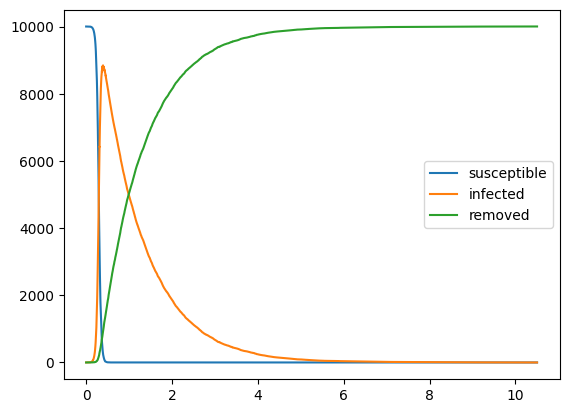

In [6]:
plt.plot(T, s, label="susceptible")
plt.plot(T, i, label="infected")
plt.plot(T, r, label="removed")

plt.legend()
plt.show()

## Simulation of SIR

In [7]:
def create_system(beta, gamma):
    def system(t, y):
        s, i, r = y
        
        ds = -beta * i * s
        di = beta * i * s - gamma * i
        dr = gamma * i
        
        return [ds, di, dr]
        
    return system 

In [8]:
def SIR(N, t_span, beta, gamma):
    system = create_system(beta, gamma)
    y0 = [1-1/N, 1/N, 0]

    sol = solve_ivp(system, t_span, y0)
    
    return sol.t, sol.y[0], sol.y[1], sol.y[2]

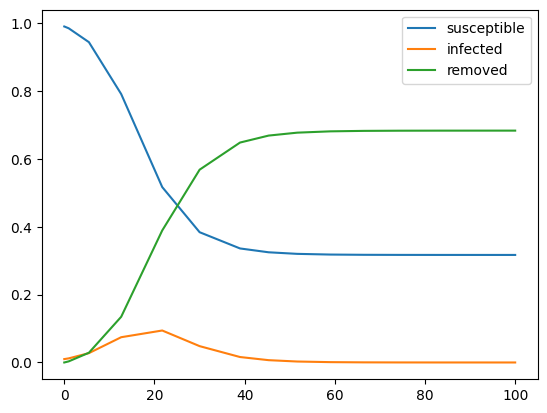

In [9]:
t, s, i, r = SIR(100, (0,100), 0.5,0.3)
plt.plot(t, s, label='susceptible')
plt.plot(t, i, label='infected')
plt.plot(t, r, label='removed')
plt.legend()
plt.show()